In [50]:
import scipy.stats as st
import pandas as pd 
import seaborn as sns
from pylab import mpl 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
plt.rcParams['font.sans-serif'] = ['STSong']
mpl.rcParams['font.sans-serif'] = ['STSong'] # 指定默认字体 
mpl.rcParams['axes.unicode_minus'] = False


In [51]:
df1 = pd.read_csv('./data/file1.csv')
df4 = pd.read_csv('./data/file4.csv')


In [52]:
df_11 = df1[['carid','price']]
df4 = df_11.merge(df4,on='carid')

# 将最新的定价作为price 和提取降价次数、幅度特征

In [53]:
# 将最后一次调整价格的时间，作为pushDate，最新的价格作为pushPrice
def clear_time(txt_json):
    if txt_json == '{}':
        return np.nan
    else:
        update_time = txt_json[2:-2].split(',')[-1].split(':')[0].strip()[2:-2]
        update_price = txt_json[2:-
                                2].split(',')[-1].split(':')[1].strip()[2:-2]
        barging_times = len(txt_json[2:-2].split(','))
        new_str = update_time+','+update_price+','+str(barging_times)
        return new_str


df4['updatePriceTimeJson'] = df4['updatePriceTimeJson'].progress_apply(
    clear_time)
sep = df4['updatePriceTimeJson'].astype(str).str.split(',', expand=True)
df4['update_time'] = sep[0].astype(str)
df4['update_price'] = sep[1].astype(float)
# 提取降价次数特征
df4['barging_times'] = sep[2].astype(float)
# 提取降价幅度特征
df4['barging_price'] = np.nan
for i in range(df4.shape[0]):
    update_time = df4['update_time'][i]
    update_price = df4['update_price'][i]
    if pd.isnull(update_price) == False:
        df4['pushDate'][i] = update_time
        df4['pushPrice'][i] = update_price
        df4['barging_price'][i] = df4['price'][i]-update_price
    else:
        df4['barging_price'][i] = 0
# df4 = tmpdf4.copy()

100%|██████████| 10000/10000 [00:00<00:00, 205441.00it/s]


# 1 数据预处理

In [54]:
df_trans = df4[df4.withdrawDate.notna()]
df_trans.shape

(8000, 11)

## 1.1 计算交易周期

In [55]:
df_trans['pushDate'] = pd.to_datetime(df_trans['pushDate'])
df_trans['withdrawDate'] = pd.to_datetime(df_trans['withdrawDate'])
trans_circle = pd.DataFrame(df_trans['withdrawDate'] - df_trans['pushDate'])
df_trans['transcycle'] = trans_circle[0]

In [56]:
# 转为整型
sep = df_trans['transcycle'].astype(str).str.split(' ', expand=True)
df_trans['transcycle'] = sep[0].astype(int)
df4['transcycle'] = sep[0].astype(int)


In [57]:
# 取file4中与file1中相同cardid的数据
trans_circle_info = df1[df1.carid.isin(df4.carid.tolist())]
# trans_circle_info.info()

In [58]:
df5 = df4[['carid','transcycle','barging_times','barging_price']]

In [59]:
NEW_trans_circle = trans_circle_info.merge(df5,on='carid')
NEW_trans_circle

,carid,tradeTime,brand,serial,model,mileage,color,cityId,carCode,transferCount,...,anonymousFeature10,anonymousFeature11,anonymousFeature12,anonymousFeature13,anonymousFeature14,anonymousFeature15,price,transcycle,barging_times,barging_price
0,2,2021-06-25,2,2,2,8.60,1,2,1.0,0,...,3.0,1+2,4630*1775*1480,201609.0,2,NaN,7.38,28.0,NaN,0.0
1,6,2021-06-29,6,6,6,6.04,1,3,1.0,3,...,2.0,1,4500*1834*1707,201608.0,2,NaN,4.38,1.0,NaN,0.0
2,7,2021-06-30,7,7,7,5.70,4,1,2.0,2,...,2.0,1,4315*1783*1606,201204.0,1,NaN,5.90,19.0,NaN,0.0
3,10,2021-06-08,2,10,10,13.02,1,2,3.0,1,...,3.0,1,4285*1690*1450,NaN,1,NaN,1.49,0.0,NaN,0.0
4,12,2021-06-16,10,12,12,7.03,5,3,2.0,0,...,3.0,NaN,4150*1640*1535,201005.0,2,NaN,0.30,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,46121,2020-05-25,8,8,8,10.00,5,1,2.0,0,...,3.0,NaN,4415*1674*1415,201003.0,2,NaN,2.80,NaN,NaN,0.0
9996,8883,2021-03-20,12,275,2606,9.21,1,1,1.0,1,...,2.0,1+2,4845*1805*1695,201507.0,1,NaN,18.60,NaN,2.0,0.0
9997,63828,2021-05-26,20,209,11210,4.17,5,1,1.0,0,...,NaN,1+2,4449*1804*1535,201903.0,2,NaN,19.30,NaN,1.0,0.0
9998,5526,2020-12-17,1,59,1994,4.80,1,16,1.0,0,...,2.0,1,4032*1680*1470,201609.0,2,NaN,2.44,NaN,NaN,0.0


## 1.2 交易周期分桶

In [60]:
# 分成三类，没卖出去，为一类
NEW_trans_circle.loc[NEW_trans_circle[NEW_trans_circle['transcycle']<= 7].index, 'trans_category'] = 1
NEW_trans_circle.loc[NEW_trans_circle[NEW_trans_circle['transcycle']> 7].index, 'trans_category'] = 2

In [61]:

# 没卖出去的，交易周期编码为0
NEW_trans_circle['trans_category'] = NEW_trans_circle['trans_category'].fillna(0)
NEW_trans_circle['carCode'] = NEW_trans_circle['carCode'].fillna(1)
NEW_trans_circle['maketype'] = NEW_trans_circle['maketype'].fillna(2)


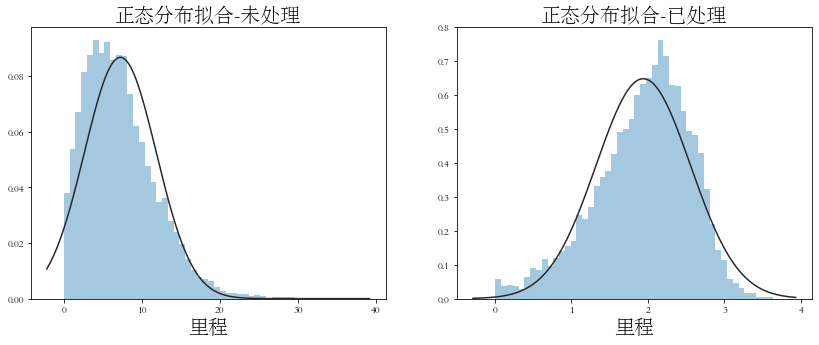

In [62]:
plt.figure(figsize=(14, 5))
plt.subplot(122)
plt.title('正态分布拟合-已处理', fontsize=20)
sns.distplot(np.log1p(NEW_trans_circle['mileage']), kde=False, fit=st.norm)
plt.xlabel('里程', fontsize=20)
plt.subplot(121)
plt.title('正态分布拟合-未处理', fontsize=20)
sns.distplot(NEW_trans_circle['mileage'], kde=False, fit=st.norm)
plt.xlabel('里程', fontsize=20)
plt.savefig('img/Q2-img/1 里程正态分布拟合.png',dpi=300)
# plt.savefig('img/test2.png')


## 1.3 里程分桶

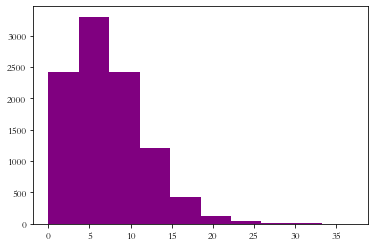

In [63]:
# y_p = NEW_trans_circle[NEW_trans_circle['mileage'] <= 200]
y_p = NEW_trans_circle
## 3) 查看预测值的具体频数
plt.hist(y_p['mileage'], orientation='vertical',
         histtype='bar', color='purple')
plt.savefig('img/Q2-img/2 里程分桶.png',dpi=300)
plt.show()

In [64]:
NEW_trans_circle['trans_category'].value_counts()

2.0    4273
1.0    3727
0.0    2000
Name: trans_category, dtype: int64

In [65]:
NEW_trans_circle.loc[NEW_trans_circle[NEW_trans_circle['mileage']<= 10].index, 'mileage_category'] = 1
NEW_trans_circle.loc[NEW_trans_circle[(NEW_trans_circle['mileage']> 10)&(NEW_trans_circle['mileage']<= 20)].index, 'mileage_category'] = 2
NEW_trans_circle.loc[NEW_trans_circle[(NEW_trans_circle['mileage']> 20)&(NEW_trans_circle['mileage']<= 30)].index, 'mileage_category'] = 3
NEW_trans_circle.loc[NEW_trans_circle[(NEW_trans_circle['mileage']> 30)].index, 'mileage_category'] = 4

## 1.4 排量分桶

In [66]:
#微型轿车（排量为1L以下）、普通级轿车（排量为1.0~1.6L)、中级轿车（排量为1.6~2.5L）、中高级轿车（排量为2.5~4.0L）、高级轿车（排量为4L以上）
NEW_trans_circle.loc[NEW_trans_circle[NEW_trans_circle['displacement']<= 1].index, 'displacement_category'] = 1
NEW_trans_circle.loc[NEW_trans_circle[(NEW_trans_circle['displacement']> 1)&(NEW_trans_circle['displacement']<= 1.6)].index, 'displacement_category'] = 2
NEW_trans_circle.loc[NEW_trans_circle[(NEW_trans_circle['displacement']> 1.6)&(NEW_trans_circle['displacement']<=2.5)].index, 'displacement_category'] = 3
NEW_trans_circle.loc[NEW_trans_circle[(NEW_trans_circle['displacement']> 2.5)&(NEW_trans_circle['displacement']<=4.0)].index, 'displacement_category'] = 4
NEW_trans_circle.loc[NEW_trans_circle[(NEW_trans_circle['displacement']> 4.0)].index, 'displacement_category'] = 5

## 1.5 价格分桶

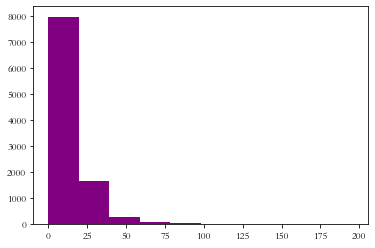

In [67]:
# y_p = NEW_trans_circle[NEW_trans_circle['mileage'] <= 200]
y_p = NEW_trans_circle[NEW_trans_circle['price']<200]
## 3) 查看预测值的具体频数
plt.hist(y_p['price'], orientation='vertical',
         histtype='bar', color='purple')
# plt.savefig('/home/mgege007/Desktop/price_bar1.png')
plt.show()

In [68]:
# 15w下，15-35W 35-75W 75-250W 250w上，对应低端，中端，中高端，高端，豪车
NEW_trans_circle.loc[NEW_trans_circle[NEW_trans_circle['price']<= 15].index, 'price_category'] = 1 # 低端价
NEW_trans_circle.loc[NEW_trans_circle[(NEW_trans_circle['price']> 15)&(NEW_trans_circle['price']<= 35)].index, 'price_category'] = 2 # 中端价
NEW_trans_circle.loc[NEW_trans_circle[(NEW_trans_circle['price']> 35)&(NEW_trans_circle['price']<= 75)].index, 'price_category'] = 3 # 中高端价
NEW_trans_circle.loc[NEW_trans_circle[(NEW_trans_circle['price']> 75)&(NEW_trans_circle['price']<= 250)].index, 'price_category'] = 4 # 高端价
NEW_trans_circle.loc[NEW_trans_circle[(NEW_trans_circle['price']> 250)].index, 'price_category'] = 5 # 豪车价

In [69]:
cols = ["carid", "tradeTime", "brand", "serial", "model", "mileage", "color", "cityId", "carCode", "transferCount", "seatings", "registerDate",
        "licenseDate", "country", "maketype", "modelyear", "displacement", "gearbox", "oiltype", "newprice", "price",'barging_times',
        'barging_price','price_category','displacement_category','mileage_category','trans_category','transcycle']
df = NEW_trans_circle[cols]


## 1.6 缺失值处理

In [70]:
# 以下分类特征全部填充众数
df['carCode'] = df['carCode'].fillna(1)
df['modelyear'] = df['modelyear'].fillna(2017)
df['country'] = df['country'].fillna(779412)
df['maketype'] = df['maketype'].fillna(2)
df['gearbox'] = df['gearbox'].fillna(3)
df['barging_times'] = df['barging_times'].fillna(0)
df['barging_price'] = df['barging_price'].fillna(0)
df['transcycle'] = df['transcycle'].fillna(0)

## 1.7 提取时间特征

In [71]:
# # 时间处理(提取年月日)
df['tradeTime'] = pd.to_datetime(df['tradeTime'])
df['registerDate'] = pd.to_datetime(df['registerDate'])
df['licenseDate'] = pd.to_datetime(df['licenseDate'])


df['tradeTime_year'] = df['tradeTime'].dt.year
df['tradeTime_month'] = df['tradeTime'].dt.month
df['tradeTime_day'] = df['tradeTime'].dt.day

df['registerDate_year'] = df['registerDate'].dt.year
df['registerDate_month'] = df['registerDate'].dt.month
df['registerDate_day'] = df['registerDate'].dt.day

df['licenseDate_year'] = df['licenseDate'].dt.year
df['licenseDate_month'] = df['licenseDate'].dt.month
df['licenseDate_day'] = df['licenseDate'].dt.day

del df['tradeTime']
del df['registerDate']
del df['licenseDate']


## 1.8 数据分布的转换

In [72]:
# 删除训练集中异常值
# df_train = train.drop(train[abs(train['newprice']-train['price']) > 100].index)
df_a = df.copy()
df_a['price'] = np.log1p(df_a['price'])
df_a['newprice'] = np.log1p(df_a['newprice'])
df_a['mileage'] = np.log1p(df_a['mileage'])
df_a


,carid,brand,serial,model,mileage,color,cityId,carCode,transferCount,seatings,...,transcycle,tradeTime_year,tradeTime_month,tradeTime_day,registerDate_year,registerDate_month,registerDate_day,licenseDate_year,licenseDate_month,licenseDate_day
0,2,2,2,2,2.261763,1,2,1.0,0,5,...,28.0,2021,6,25,2016,12,1,2017,3,21
1,6,6,6,6,1.951608,1,3,1.0,3,5,...,1.0,2021,6,29,2016,8,1,2016,9,9
2,7,7,7,7,1.902108,4,1,2.0,2,5,...,19.0,2021,6,30,2012,8,1,2012,8,28
3,10,2,10,10,2.640485,1,2,3.0,1,5,...,0.0,2021,6,8,2006,10,1,2006,11,27
4,12,10,12,12,2.083185,5,3,2.0,0,5,...,0.0,2021,6,16,2011,10,1,2012,3,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,46121,8,8,8,2.397895,5,1,2.0,0,5,...,0.0,2020,5,25,2012,6,1,2012,8,17
9996,8883,12,275,2606,2.323368,1,1,1.0,1,7,...,0.0,2021,3,20,2016,11,1,2016,12,6
9997,63828,20,209,11210,1.642873,5,1,1.0,0,5,...,0.0,2021,5,26,2018,11,1,2019,2,18
9998,5526,1,59,1994,1.757858,1,16,1.0,0,5,...,0.0,2020,12,17,2016,9,1,2016,10,12


In [73]:
df_a.isnull().any().value_counts()

False    34
dtype: int64

## 1.9 筛选价格回归关键因素

In [74]:
# 筛选与price相关系数大于0.1的特征
mcorr = df_a.corr(method='spearman').abs()

tt = mcorr['price'] > 0.05
new_col = list(tt[tt == True].index)
new_col.remove('price')
# 删除共线性的三个特征，registerDate_year、modelyear
new_col.remove('licenseDate_year')
new_col.remove('modelyear')

df_D = df_a[new_col]
df_D['price'] = df_a['price']
df_D['trans_category'] = df_a['trans_category']

len(new_col)


18

In [75]:
mcorr = df_a.corr(method='spearman').abs()
trans_df = pd.DataFrame(mcorr['transcycle']).sort_values(by='transcycle',ascending=False)
del trans_df['transcycle']

In [76]:
dict = {
 'model':'车型ID',
 'brand':'品牌ID',
 'mileage':'里程',
 'serial':'车系ID',
 'color':'颜色',
 'cityId':'城市ID',
 'oiltype':'燃油类型',
 'carCode':'国标码',
 'seatings':'载客人数',
 'country':'国别',
 'maketype':'厂商类型',
 'displacement':'排量',
 'displacement_category':'排量类别',
 'gearbox':'变速箱',
 'newprice':'新车价',
 'price':'价格',
 'transferCount':'过户次数',
 'modelyear':'年款',
 'price':'价格',
 'barging_times':'降价次数',
 'price_category':'价格级别',
 'mileage_category':'里程类别',
 'tradeTime_year':'展销年份',
 'registerDate_year':"注册年份",
 'licenseDate_month':'上牌月份',
 'licenseDate_year':"上牌时间"}
mcorr_df = pd.DataFrame(mcorr[mcorr['price']> 0.05]['price'])
# mcorr_df['price'].shape
mcorr_df2 = mcorr_df.rename(dict)
# mcorr_df2.T.to_csv('./data/Q2/第二问与价格的相关性.csv',index=False)

In [77]:
mcorr_df = pd.DataFrame(mcorr[mcorr['transcycle']> 0.02]['transcycle'])
mcorr_df2 = mcorr_df.rename(dict)
# mcorr_df2.T.to_csv('./data/Q2/第二问与交易周期的相关性.csv',index=False)

## 1.10 筛选与交易周期的关键因素

In [78]:
mcorr_df2 =mcorr_df2.sort_values(by='transcycle',ascending=False)
mcorr_df2

,transcycle
transcycle,1.000000
trans_category,0.918109
城市ID,0.128278
展销年份,0.097179
降价次数,0.049157
燃油类型,0.033391
车系ID,0.031077
上牌时间,0.029047
里程,0.028805
注册年份,0.028352


In [79]:
dict = {
 'model':'车型ID',
 'transcycle':'交易周期',
 'trans_category':'交易周期类别',
 'brand':'品牌ID',
 'mileage':'里程',
 'serial':'车系ID',
 'color':'颜色',
 'cityId':'城市ID',
 'oiltype':'燃油类型',
 'carCode':'国标码',
 'seatings':'载客人数',
 'country':'国别',
 'maketype':'厂商类型',
 'displacement':'排量',
 'displacement_category':'排量类别',
 'gearbox':'变速箱',
 'newprice':'新车价',
 'price':'价格',
 'transferCount':'过户次数',
 'modelyear':'年款',
 'price':'价格',
 'barging_times':'降价次数',
 'price_category':'价格级别',
 'mileage_category':'里程类别',
 'tradeTime_year':'展销年份',
 'registerDate_year':"注册年份",
 'registerDate_month':"注册月份",
 'licenseDate_month':'上牌月份',
 'licenseDate_year':"上牌时间"}

mcorr = df_a.corr(method='spearman').abs()
correlation = mcorr[mcorr['transcycle']>0.02]['transcycle']
del correlation['transcycle']
del correlation['trans_category']
col = list(correlation)
idx = list(correlation.index)
map_df = pd.DataFrame(idx,columns=['f'])
map_df = map_df['f'].map(dict)
row = list(map_df)



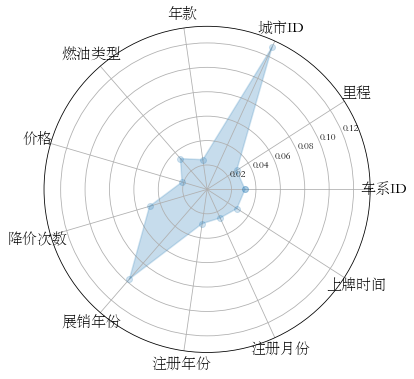

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pylab import mpl 
mpl.rcParams['font.sans-serif'] = ['STSong'] # 指定默认字体 
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] =['STSong']
import warnings
warnings.filterwarnings('ignore')
dataset = pd.DataFrame(data=col,index=row,columns=['影响交易周期的关键因素'])
radar_labels=dataset.index
nAttr=dataset.shape[0]
data=dataset.values #数据值
data_labels=dataset.columns
# 设置角度
angles=np.linspace(0,2*np.pi,nAttr,
                   endpoint= False)
data=np.concatenate((data, [data[0]])) 
angles=np.concatenate((angles, [angles[0]]))
# 设置画布
fig=plt.figure(facecolor="white",figsize=(10,6))
plt.subplot(111, polar=True)
# 绘图
plt.plot(angles,data,'o-',
         linewidth=1.5, alpha= 0.2)
# 填充颜色
plt.fill(angles,data, alpha=0.25) 
plt.thetagrids(angles[:-1]*180/np.pi, 
               radar_labels,1.2,fontsize=15) 
plt.grid(True)
plt.savefig('img/Q2-img/3 影响交易周期的关键因素.png',dpi=300)
plt.show()

In [81]:
df_D[df_D['trans_category'] == 1].shape

(3727, 20)

In [82]:
df_D[df_D['trans_category'] == 0].shape

(2000, 20)

In [83]:
df_D[df_D['trans_category'] == 2].shape

(4273, 20)

## 1.11 存储将要回归分析的数据

In [84]:
# df_D[df_D['trans_category']==0].to_csv('./data/Q2/Q2_没卖出20.csv', index=0)
# df_D[df_D['trans_category'] == 1].to_csv('./data/Q2/Q2_一周内卖出20.csv', index=0)
# df_D[df_D['trans_category'] == 2].to_csv('./data/Q2/Q2_一周之后卖出20.csv', index=0)
# df_D.to_csv('./data/Q2/Q2_所有数据.csv', index=0)


## 1.12 存储要对应分析的数据

In [85]:
# 分析所在城市、展销年份、降价次数和价格 与交易周期的关系
# df_a[['cityId','tradeTime_year','barging_times','trans_category']].to_csv('./data/Q2/交易周期的对应分析.csv',index=False)

In [86]:
tmpdf = df_a[['cityId','tradeTime_year','barging_times','trans_category']]
tmpdf['tradeTime_year'].value_counts()

2020    5827
2021    4173
Name: tradeTime_year, dtype: int64

In [87]:
year2020 = list(tmpdf[tmpdf['tradeTime_year']==2020]['trans_category'].value_counts())
year2020.sort()
year2020

[1030, 2142, 2655]

In [88]:
year2021 = list(tmpdf[tmpdf['tradeTime_year']==2021]['trans_category'].value_counts())
year2021.sort()
year2021

[970, 1585, 1618]

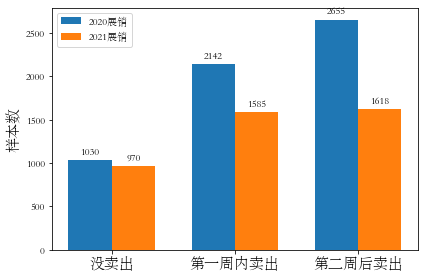

In [94]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['STsong']

labels = ['没卖出', '第一周内卖出', '第二周后卖出']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, year2020, width, label='2020展销')
rects2 = ax.bar(x + width/2, year2021, width, label='2021展销')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('样本数',fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=15)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('./img/Q2-img/6 展销因素与交易周期关系的柱状图.png',dpi=300)
plt.show()



In [152]:
# 城市ID与交易周期的关系
tmpdf[tmpdf['trans_category']==1]['cityId'].value_counts()

1     1662
17     372
19     342
14     322
3      238
15     129
7      124
4      115
5      106
2       71
18      52
9       24
13      21
35      20
20      17
28      16
12      14
27       7
8        7
10       7
16       7
22       6
23       5
6        4
11       4
41       3
67       2
55       2
49       2
29       2
31       2
40       2
34       2
71       1
24       1
26       1
62       1
32       1
38       1
48       1
52       1
68       1
80       1
65       1
61       1
87       1
45       1
43       1
21       1
25       1
91       1
Name: cityId, dtype: int64

In [153]:
tmpdf[tmpdf['trans_category']==0]['cityId'].value_counts()

1     864
7     250
3     109
17    105
4      96
19     83
14     65
5      62
8      55
15     43
18     36
35     26
28     21
13     21
9      18
12     16
2      16
20     16
16     14
23     13
22      9
6       7
24      7
43      5
10      5
30      5
21      4
31      3
39      3
11      3
55      2
29      2
32      2
54      2
45      2
76      1
64      1
78      1
62      1
27      1
60      1
41      1
38      1
80      1
86      1
Name: cityId, dtype: int64

In [154]:
tmpdf[tmpdf['trans_category']==2]['cityId'].value_counts()

1     1324
17     408
3      329
7      290
4      281
      ... 
62       1
66       1
86       1
47       1
75       1
Name: cityId, Length: 71, dtype: int64

# 2 聚类

## 2.1 第一周聚类,K值的确定

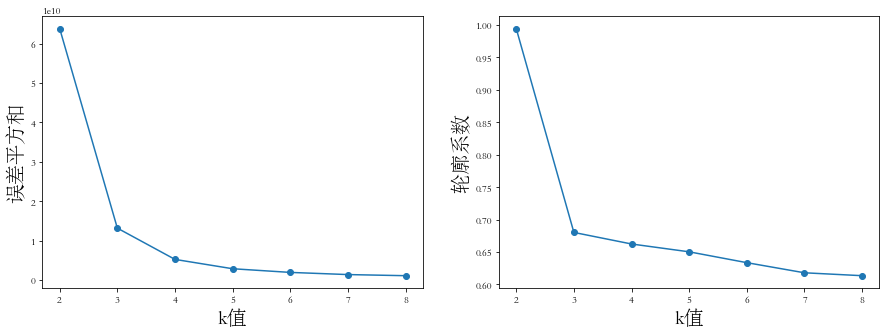

In [99]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.rcParams['font.sans-serif'] = ['STSong']
df = pd.read_csv('./data/Q2/Q2_一周内卖出20.csv')
data = np.array(df)

Scores = []  # 存放轮廓系数
SSE = []  # 存放每次结果的误差平方和
for k in range(2, 9):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(data)
    Scores.append(silhouette_score(
        np.array(df), estimator.labels_, metric='euclidean'))
    SSE.append(estimator.inertia_) # estimator.inertia_获取聚类准则的总和
X = range(2,9)
X = range(2, 9)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.xlabel('k值',fontsize=20)
plt.ylabel('误差平方和',fontsize=20)
plt.plot(X, SSE, 'o-')
plt.subplot(122)
plt.xlabel('k值',fontsize=20)
plt.ylabel('轮廓系数',fontsize=20)
plt.plot(X, Scores, 'o-')

plt.savefig('./img/Q2-img/7 手肘法.png',dpi=300)
plt.show()

## 2.2 聚类随机种子的确定

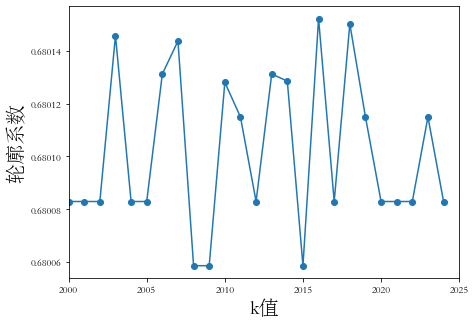

In [102]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.rcParams['font.sans-serif'] =  ['STSong']
df = pd.read_csv('./data/Q2/Q2_一周内卖出20.csv')
data = np.array(df)

Scores = []  # 存放轮廓系数
for i in range(2000,2025):
    estimator = KMeans(n_clusters=3, random_state=i)  # 构造聚类器
    estimator.fit(data)
    Scores.append(silhouette_score(np.array(df), estimator.labels_, metric='euclidean'))
X = range(2000, 2025)
plt.figure(figsize=(7,5))
plt.xlabel('k值',fontsize=20)
plt.ylabel('轮廓系数',fontsize=20)
plt.plot(X, Scores, 'o-')
plt.xlim(2000, 2025)

plt.savefig('./img/Q2-img/8 随机种子的确定.png',dpi=300)
plt.show()


## 2.3 第二周之后的样本分类

0.6801521645711021 0.6626868348367989 0.6769216001120795


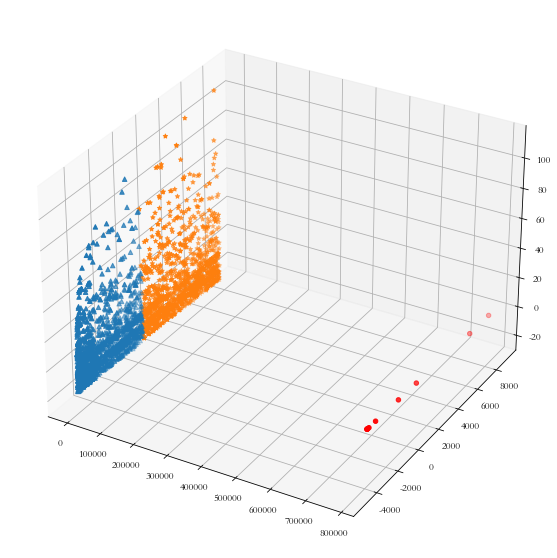

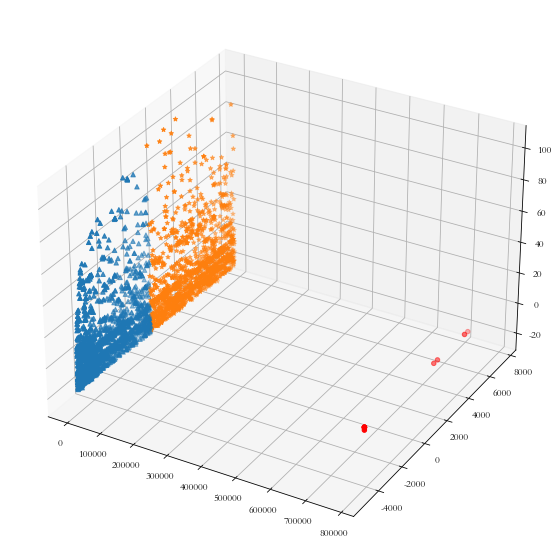

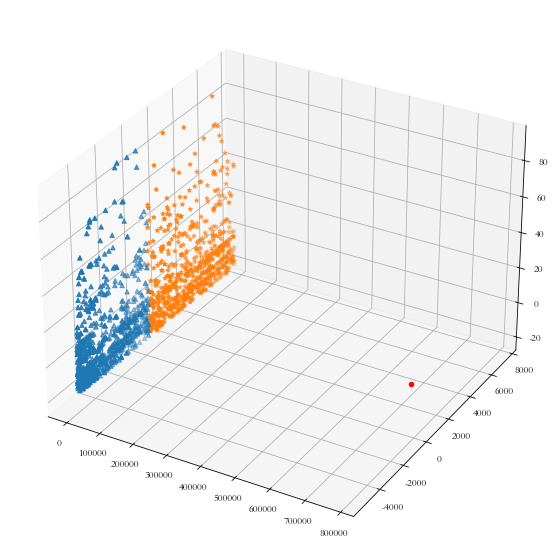

In [122]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
df1 = pd.read_csv('./data/Q2/Q2_一周内卖出20.csv')
data1 = np.array(df1)

df0 = pd.read_csv('./data/Q2/Q2_没卖出20.csv')
data0 = np.array(df0)

df2 = pd.read_csv('./data/Q2/Q2_一周之后卖出20.csv')
data2 = np.array(df2)

clf0 = KMeans(n_clusters=3, init='k-means++',random_state=2016)
clf1 = KMeans(n_clusters=3, init='k-means++',random_state=2016)
clf2 = KMeans(n_clusters=3, init='k-means++',random_state=2016)
# s = clf.fit(data1)
pred0 = clf0.fit_predict(data0)
pred1 = clf1.fit_predict(data1)
pred2 = clf2.fit_predict(data2)
score0 = silhouette_score(data0, pred0)
score1 = silhouette_score(data1, pred1)
score2 = silhouette_score(data2, pred2)
print(score1,score0,score2)
pca = PCA(n_components=3)  # 输出两维
newData0 = pca.fit_transform(data0)  # 载入N维
newData1 = pca.fit_transform(data1)  # 载入N维
newData2 = pca.fit_transform(data2)  # 载入N维

x1, y1, z1 = [], [], []
x2, y2, z2 = [], [], []
x3, y3, z3 = [], [], []
for index, value in enumerate(pred1):
    if value == 0:
        x1.append(newData1[index][0])
        y1.append(newData1[index][1])
        z1.append(newData1[index][2])
    elif value == 1:
        x2.append(newData1[index][0])
        y2.append(newData1[index][1])
        z2.append(newData1[index][2])
    elif value == 2:
        x3.append(newData1[index][0])
        y3.append(newData1[index][1])
        z3.append(newData1[index][2])
# plt.subplot(132)
plt.figure(figsize=(10, 10))

# #定义坐标轴
ax1 = plt.axes(projection='3d')
ax1.scatter3D(x1, y1, z1,marker='^')
ax1.scatter3D(x2, y2, z2, marker='o',c='r')
ax1.scatter3D(x3, y3, z3, marker='*')
plt.savefig('./img/Q2-img/9 第一周卖出的数据分布三维.png',dpi=300)
plt.show()


x1, y1, z1 = [], [], []
x2, y2, z2 = [], [], []
x3, y3, z3 = [], [], []
for index, value in enumerate(pred2):
    if value == 0:
        x1.append(newData2[index][0])
        y1.append(newData2[index][1])
        z1.append(newData2[index][2])
    elif value == 1:
        x2.append(newData2[index][0])
        y2.append(newData2[index][1])
        z2.append(newData2[index][2])
    elif value == 2:
        x3.append(newData2[index][0])
        y3.append(newData2[index][1])
        z3.append(newData2[index][2])
# #定义坐标轴
plt.figure(figsize=(10, 10))
# plt.subplot(132)
ax1 = plt.axes(projection='3d')
ax1.scatter3D(x1, y1, z1,marker='^')
ax1.scatter3D(x2, y2, z2, marker='o',c='r')
ax1.scatter3D(x3, y3, z3, marker='*')
plt.savefig('./img/Q2-img/10 第二周之后卖出的数据分布三维.png',dpi=300)
plt.show()

x1, y1, z1 = [], [], []
x2, y2, z2 = [], [], []
x3, y3, z3 = [], [], []
for index, value in enumerate(pred0):
    if value == 0:
        x1.append(newData0[index][0])
        y1.append(newData0[index][1])
        z1.append(newData0[index][2])
    elif value == 1:
        x2.append(newData0[index][0])
        y2.append(newData0[index][1])
        z2.append(newData0[index][2])
    elif value == 2:
        x3.append(newData0[index][0])
        y3.append(newData0[index][1])
        z3.append(newData0[index][2])
# #定义坐标轴
# plt.subplot(133)
plt.figure(figsize=(10, 10))
ax1 = plt.axes(projection='3d')
ax1.scatter3D(x1, y1, z1,marker='^')
ax1.scatter3D(x2, y2, z2, marker='o',c='r')
ax1.scatter3D(x3, y3, z3, marker='*')
plt.savefig('./img/Q2-img/11 没卖出的数据分布三维.png',dpi=300)

plt.show()


In [12]:
# 输出三个类别的聚类中心
center_df = pd.DataFrame(clf1.cluster_centers_,columns=df0.columns)
center_df.to_csv('./data/Q2/三个类别的聚类中心.csv',index=0)


In [127]:
df1[pred1 == 2].shape

(1603, 20)

In [50]:
df1[pred1 == 0].to_csv('./data/Q2/第一周20/Q2_cluster_week1_1.csv', index=False)
df1[pred1 == 1].to_csv('./data/Q2/第一周20/Q2_cluster_week1_2.csv', index=False)
df1[pred1 == 2].to_csv('./data/Q2/第一周20/Q2_cluster_week1_3.csv', index=False)

df2[pred2 == 0].to_csv('./data/Q2/第二周之后20/Q2_cluster_week2_1.csv', index=False)
df2[pred2 == 1].to_csv('./data/Q2/第二周之后20/Q2_cluster_week2_2.csv', index=False)
df2[pred2 == 2].to_csv('./data/Q2/第二周之后20/Q2_cluster_week2_3.csv', index=False)

df0[pred0 == 0].to_csv('./data/Q2/没卖出20/Q2_cluster_week0_1.csv', index=False)
df0[pred0 == 1].to_csv('./data/Q2/没卖出20/Q2_cluster_week0_2.csv', index=False)
df0[pred0 == 2].to_csv('./data/Q2/没卖出20/Q2_cluster_week0_3.csv', index=False)


# 3 回归分析

## 3.1 多元回归方程拟合

In [104]:
import pandas as pd
import numpy as np
week1_data_1 = pd.read_csv('./data/Q2/第一周20/Q2_cluster_week1_1.csv')
week1_data_2 = pd.read_csv('./data/Q2/第一周20/Q2_cluster_week1_2.csv')
week1_data_3 = pd.read_csv('./data/Q2/第一周20/Q2_cluster_week1_3.csv')

week2_data_1 = pd.read_csv('./data/Q2/第二周之后20/Q2_cluster_week2_1.csv')
week2_data_2 = pd.read_csv('./data/Q2/第二周之后20/Q2_cluster_week2_2.csv')
week2_data_3 = pd.read_csv('./data/Q2/第二周之后20/Q2_cluster_week2_3.csv')


week0_data_1 = pd.read_csv('./data/Q2/没卖出20/Q2_cluster_week0_1.csv')
week0_data_2 = pd.read_csv('./data/Q2/没卖出20/Q2_cluster_week0_2.csv')
week0_data_3 = pd.read_csv('./data/Q2/没卖出20/Q2_cluster_week0_3.csv')


In [105]:
# 由于modelyear、registerDate_year和licenseDate_year共线，只保留，rigerterDate_year
cols = ['brand', 'model', 'mileage', 'color', 'cityId', 'carCode', 'seatings',
       'country', 'maketype', 'displacement', 'gearbox',
       'newprice', 'barging_times', 'registerDate_year',
       'licenseDate_month']
cols2 = ['brand', 'model', 'mileage', 'color', 'cityId', 'carCode', 'seatings',
       'country', 'maketype', 'displacement', 'gearbox',
       'newprice', 'barging_times', 'registerDate_year',
       'licenseDate_month','price']
week1_X1 = week1_data_1[cols]
week1_y1  = week1_data_1['price']
week1_X2 = week1_data_2[cols]
week1_y2  = week1_data_2['price']

week1_X3 = week1_data_3[cols]
week1_y3  = week1_data_3['price']

week2_X1 = week2_data_1[cols]
week2_y1  = week2_data_1['price']
week2_X3 = week2_data_3[cols]
week2_y3  = week2_data_3['price']


week0_X1 = week0_data_1[cols]
week0_y1  = week0_data_1['price']
week0_X3 = week0_data_3[cols]
week0_y3  = week0_data_3['price']



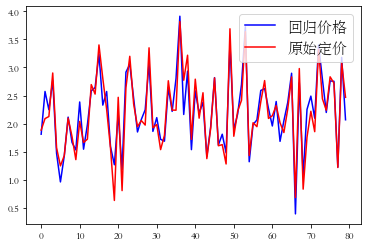

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
X_train,X_test,y_train,y_test=train_test_split(week1_X1,week1_y1,test_size=.9,random_state=0)
linreg=LinearRegression()
model=linreg.fit(X_train,y_train)
y_pred=linreg.predict(X_test)

plt.figure()
plt.plot(range(len(y_pred[100:180])),y_pred[100:180],'b',label="回归价格")
plt.plot(range(len(y_pred[100:180])),y_test[100:180],'r',label="原始定价")
plt.legend(loc="upper right",prop = {'size':15})
plt.savefig('./img/Q2-img/12 第一周第一个方程.png',dpi=300)
plt.show()



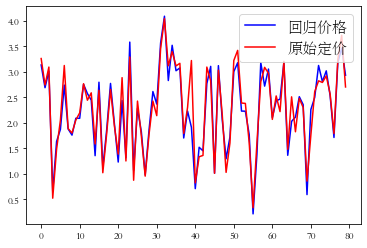

In [109]:
# 第三个方程
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
X_train,X_test,y_train,y_test=train_test_split(week1_X3,week1_y3,test_size=.9,random_state=0)
linreg=LinearRegression()
model=linreg.fit(X_train,y_train)
y_pred=linreg.predict(X_test)

plt.figure()
plt.plot(range(len(y_pred[100:180])),y_pred[100:180],'b',label="回归价格")
plt.plot(range(len(y_pred[100:180])),y_test[100:180],'r',label="原始定价")
plt.legend(loc="upper right",prop = {'size':15})
plt.savefig('./img/Q2-img/13 第一周第三个方程.png',dpi=300)
plt.show()


In [59]:
# from statsmodels.formula.api import ols
import statsmodels.api as sm
X= sm.add_constant(week1_X1)
result = sm.OLS(week1_y1,X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     1810.
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        20:47:15   Log-Likelihood:                 388.96
No. Observations:                2114   AIC:                            -745.9
Df Residuals:                    2098   BIC:                            -655.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1451.3217   1899.417      0.764      0.445   -2273.616    5176.259
brand                -0.0030      0.000    -10.785      0.000      -0.004      -0.002
model             -5.902e-06   2.74e-06     -2.153      0.031   -1.13e-05   -5.27e-07
mileage              -0.0872      0.011     -8.053      0.000      -0.108      -0.066
color                -0.0036      0.002     -1.585      0.113      -0.008       0.001
cityId               -0.0004      0.001     -0.693      0.488      -0.001       0.001
carCode              -0.0273      0.006     -4.887      0.000      -0.038      -0.016
seatings              0.0200      0.007      2.711      0.007       0.006       0.035
country              -0.0021      0.002     -0.882      0.378      -0.007       0.003
maketype              0.0577      0.012      4.764      0.000       0.034       0.081
displacement          0.0389      0.014      2.760      0.006       0.011       0.066
gearbox               0.0013      0.001      2.428      0.015       0.000       0.002
newprice              0.9572      0.013     73.170      0.000       0.932       0.983
barging_times         0.0091      0.004      2.089      0.037       0.001       0.018
registerDate_year     0.1108      0.002     51.926      0.000       0.107       0.115
licenseDate_month    -0.0019      0.001     -1.517      0.129      -0.004       0.001
==============================================================================
Omnibus:                      126.709   Durbin-Watson:                   1.474
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.681
Skew:                          -0.550   Prob(JB):                     6.39e-37
Kurtosis:                       3.826   Cond. No.                     3.37e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
import statsmodels.api as sm
X = sm.add_constant(week1_X3)
result = sm.OLS(week1_y3,X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     920.2
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        20:47:50   Log-Likelihood:                -70.061
No. Observations:                1603   AIC:                             172.1
Df Residuals:                    1587   BIC:                             258.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3604.8065   2774.112      1.299      0.194   -1836.504    9046.117
brand                -0.0031      0.000     -9.364      0.000      -0.004      -0.002
model              1.505e-06   3.05e-06      0.493      0.622   -4.48e-06    7.49e-06
mileage              -0.0763      0.015     -4.973      0.000      -0.106      -0.046
color                 0.0021      0.003      0.642      0.521      -0.004       0.009
cityId               -0.0035      0.001     -4.981      0.000      -0.005      -0.002
carCode              -0.0053      0.008     -0.705      0.481      -0.020       0.009
seatings              0.0498      0.010      5.097      0.000       0.031       0.069
country              -0.0049      0.004     -1.382      0.167      -0.012       0.002
maketype              0.1232      0.016      7.903      0.000       0.093       0.154
displacement          0.0469      0.019      2.491      0.013       0.010       0.084
gearbox               0.0007      0.001      0.922      0.357      -0.001       0.002
newprice              0.8822      0.018     49.571      0.000       0.847       0.917
barging_times         0.0124      0.006      1.980      0.048       0.000       0.025
registerDate_year     0.1134      0.003     37.760      0.000       0.108       0.119
licenseDate_month    -0.0063      0.002     -3.485      0.001      -0.010      -0.003
==============================================================================
Omnibus:                     1501.645   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           373928.727
Skew:                           3.693   Prob(JB):                         0.00
Kurtosis:                      77.457   Cond. No.                     3.41e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.41e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
import statsmodels.api as sm
X = sm.add_constant(week1_X2)
result = sm.OLS(week1_y2,X).fit()
result.summary()

/Applications/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 09 Jan 2022   Prob (F-statistic):                nan
Time:                        21:36:18   Log-Likelihood:                 276.47
No. Observations:                  10   AIC:                            -532.9
Df Residuals:                       0   BIC:                            -529.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
brand                -0.1840        inf         -0        nan         nan         nan
model              2.733e-05        inf          0        nan         nan         nan
mileage              -0.5708        inf         -0        nan         nan         nan
color                -0.0749        inf         -0        nan         nan         nan
cityId               -0.0058        inf         -0        nan         nan         nan
carCode              -0.0747        inf         -0        nan         nan         nan
seatings             -0.0569        inf         -0        nan         nan         nan
country           -1.289e-16        inf         -0        nan         nan         nan
maketype             -0.0027        inf         -0        nan         nan         nan
displacement         -0.0019        inf         -0        nan         nan         nan
gearbox               0.1219        inf          0        nan         nan         nan
newprice              1.1967        inf          0        nan         nan         nan
barging_times         0.0445        inf          0        nan         nan         nan
registerDate_year     0.0060        inf          0        nan         nan         nan
licenseDate_month     0.0269        inf          0        nan         nan         nan
==============================================================================
Omnibus:                       12.348   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                5.946
Skew:                          -1.728   Prob(JB):                       0.0512
Kurtosis:                       4.525   Cond. No.                     7.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
[3] The condition number is large, 7.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 3.2 回归第二周的价格

In [112]:
model1 = linreg.fit(week1_X1,week1_y1)
model3 = linreg.fit(week1_X3,week1_y3)

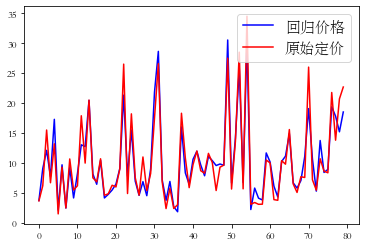

In [115]:
# 第一个类别的回归价格
cluter1_price = model1.predict(week2_X1)
x = range(80)
plt.plot(x,np.expm1(cluter1_price[30:110]),color='b',label='回归价格')
plt.plot(x,np.expm1(week2_y1[30:110]),color='r',label='原始定价')
plt.legend(loc="upper right",prop = {'size':15})
plt.rcParams['font.sans-serif'] = ['STSong']
plt.savefig('img/Q2-img/14 第二周第一个方程.png',dpi=300)

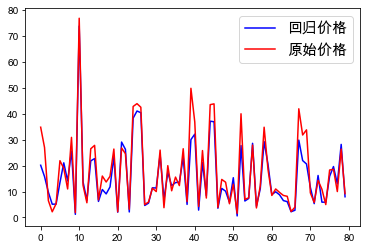

In [116]:
# 第三个类别的回归价格
cluter3_price = model3.predict(week2_X3)
x = range(80)
plt.plot(x,np.expm1(cluter3_price[100:180]),color='b',label='回归价格')
plt.plot(x,np.expm1(week2_y3[100:180]),color='r',label='原始价格')
plt.legend(loc="upper right",prop = {'size':15})
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.savefig('img/Q2-img/15 第二周第三个方程.png',dpi=300)

## 3.3 回归没卖出的价格

In [89]:
model1 = linreg.fit(week1_X1,week1_y1)
model3 = linreg.fit(week1_X3,week1_y3)

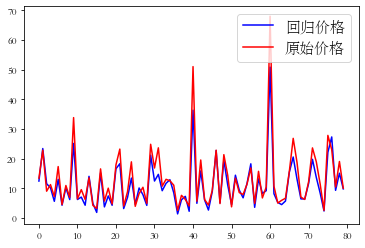

In [118]:
# 第一个类别的回归价格
cluter1_price = model1.predict(week0_X1)
x = range(80)
plt.plot(x,np.expm1(cluter1_price[100:180]),color='b',label='回归价格')
plt.plot(x,np.expm1(week0_y1[100:180]),color='r',label='原始价格')
plt.rcParams['font.sans-serif'] = ['STSong']
plt.legend(loc="upper right",prop = {'size':15})
plt.savefig('img/Q2-img/16 没卖出第一个方程.png',dpi=300)

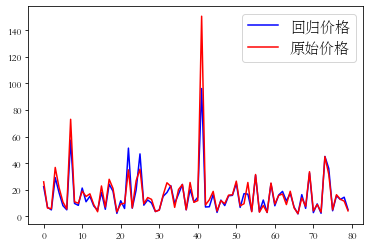

In [119]:
# 第三个类别的回归价格
cluter1_price = model1.predict(week0_X3)
x = range(80)
plt.plot(x,np.expm1(cluter1_price[100:180]),color='b',label='回归价格')
plt.plot(x,np.expm1(week0_y3[100:180]),color='r',label='原始价格')
plt.legend(loc="upper right",prop = {'size':15})
plt.rcParams['font.sans-serif'] = ['STSong']
plt.savefig('img/Q2-img/17 没卖出第三个方程.png',dpi=300)